In [22]:
import pandas as pd

In [23]:
df = pd.read_csv('Charging details report October 10, 2014 - October 21, 2022.csv')

In [24]:
df.head()

,ChargeStartDateTime,Name,Vin,Model,Country,SiteLocationName,Description,QuantityBase,QuantityTier1,QuantityTier2,...,UnitCostBase,UnitCostTier1,UnitCostTier2,UnitCostTier3,UnitCostTier4,VAT,Total Exc. VAT,Total Inc. VAT,Status,Invoice
0,2022-10-21T08:45:10+02:00,Janusz Małota,5YJSA3H19EFP46878,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,34.00 kwh,NaN,NaN,...,2.60/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
1,2022-10-04T16:04:27+02:00,Janusz Małota,5YJSA3H19EFP46878,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,24.00 kwh,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
2,2022-10-04T15:52:52+02:00,Janusz Małota,5YJSA3H19EFP46878,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,9.00 kwh,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
3,2022-10-01T13:55:09+02:00,Janusz Małota,5YJSA3H19EFP46878,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,31.00 kwh,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
4,2022-09-27T14:49:04+02:00,Janusz Małota,5YJSA3H19EFP46878,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,41.00 kwh,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN


In [25]:
df['QuantityBase'] = df['QuantityBase'].str.replace(' kwh', '').astype(float)
df['ChargeStartDateTime'] = pd.to_datetime(df['ChargeStartDateTime'], utc=True)
df['year'] = df.ChargeStartDateTime.dt.year

In [26]:
df[['City', 'Country']] = df.SiteLocationName.str.split(',', expand=True)

In [27]:
df.head()

,ChargeStartDateTime,Name,Vin,Model,Country,SiteLocationName,Description,QuantityBase,QuantityTier1,QuantityTier2,...,UnitCostTier2,UnitCostTier3,UnitCostTier4,VAT,Total Exc. VAT,Total Inc. VAT,Status,Invoice,year,City
0,2022-10-21 06:45:10+00:00,Janusz Małota,5YJSA3H19EFP46878,ms,Poland,"Krakow, Poland",CHARGING : NO_CHARGE,34.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN,2022,Krakow
1,2022-10-04 14:04:27+00:00,Janusz Małota,5YJSA3H19EFP46878,ms,Poland,"Krakow, Poland",CHARGING : NO_CHARGE,24.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN,2022,Krakow
2,2022-10-04 13:52:52+00:00,Janusz Małota,5YJSA3H19EFP46878,ms,Poland,"Krakow, Poland",CHARGING : NO_CHARGE,9.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN,2022,Krakow
3,2022-10-01 11:55:09+00:00,Janusz Małota,5YJSA3H19EFP46878,ms,Poland,"Krakow, Poland",CHARGING : NO_CHARGE,31.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN,2022,Krakow
4,2022-09-27 12:49:04+00:00,Janusz Małota,5YJSA3H19EFP46878,ms,Poland,"Krakow, Poland",CHARGING : NO_CHARGE,41.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN,2022,Krakow


# TESLA MODEL S 85 CHARGING DATA FROM 2017/03/31 TO 2022/11/11

## GENERAL STATISTICS

### TOTAL ENERGY (kwh)

In [28]:
df['QuantityBase'].sum()

10460.0

### MEAN CHARGING

In [29]:
df['QuantityBase'].mean()

31.41141141141141

### MEAN DISTANCE BETWEEN CHARGING (MEAN ENERGY CONSUMPTION = 0.2 kwh/km)

In [30]:
mean_energy_consumption = 0.2
df['QuantityBase'].mean() / mean_energy_consumption

157.05705705705705

### TOTAL COST OF ENERGY (PLN)

In [31]:
price_kwh_pln = 2.5
df['QuantityBase'].sum() * price_kwh_pln

26150.0

## STATISTICS BY YEAR

### CHARGED ENERGY BY YEAR

<AxesSubplot:xlabel='year'>

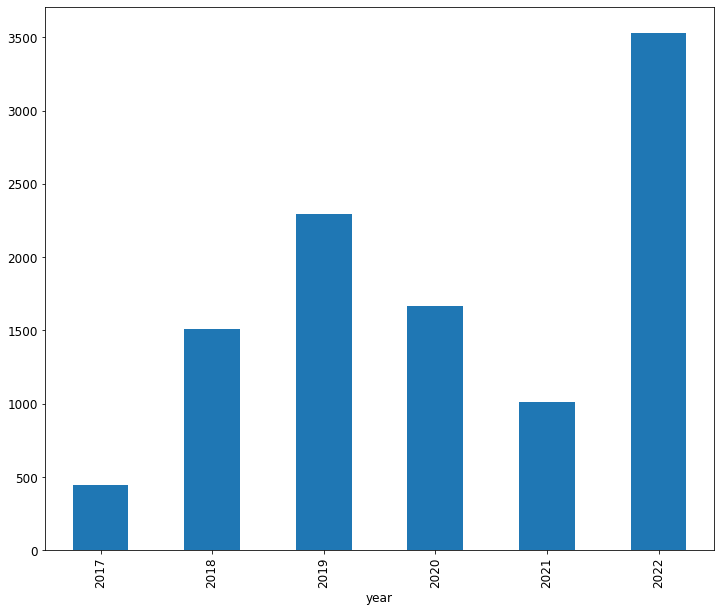

In [32]:
df.groupby('year').sum()['QuantityBase'].plot.bar()

### CHARGE COUNT BY YEAR

## CHARGED ENERGY BY COUNTRY

In [33]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action='ignore')

<AxesSubplot:>

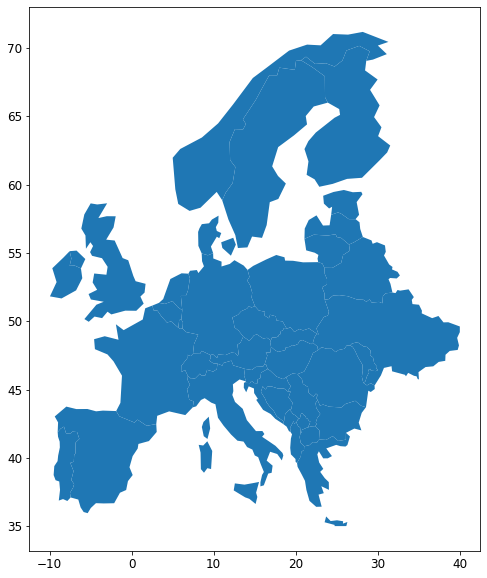

In [34]:
plt.rcParams['figure.figsize']=(12,10)
plt.rcParams['font.size']=12

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

europe=world[world.continent=='Europe']
europe=europe[(europe.name!='Russia') & (europe.name!='Iceland')]
# Create a custom polygon
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
europe=geopandas.clip(europe, polygon) 
europe.plot()


## CHARGED ENERGY BY SUPERCHARGER LOCATION